In [14]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import netCDF4
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
    data_1_FP = '/Users/hyunglokkim/data_1'
elif platform.system() == 'Linux': #workstation
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
    data_1_FP = '/home/subin/data_1'
    if not os.path.exists(cpuserver_data_FP):
        cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, '\n', cpuserver_data_FP, '\n', data_1_FP)

#hydroAI libs
import HydroAI.SMAP as hSMAP
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hSMAP);
importlib.reload(hPlot);
importlib.reload(hData);
importlib.reload(hGrid);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc/SPL3SMP'

/home/subin/data 
 /home/subin/cpuserver_data 
 /home/subin/data_1


## 1. Import and Save SMAPL3 or SMAPL3_E SM data

In [ ]:
# Usage example
mission = 'SMAP'
mission_product = 'SPL3SMP.008'
#mission_product = 'SPL3SMP_E.005'
year = 2024
directory = os.path.join(data_1_FP, mission, mission_product)
file_list, data_doy = hSMAP.extract_filelist_doy(directory, year) 
print(len(file_list), len(data_doy))
longitude, latitude = hGrid.generate_lon_lat_e2grid(resolution_key='36km')
print(np.shape(longitude), np.shape(latitude))

364 364
Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406
(406, 964) (406, 964)


In [ ]:
# Usage example - create_array_from_h5
group_name = 'Soil_Moisture_Retrieval_Data_AM'

variable_name = 'soil_moisture'
SMAP_SM_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
variable_name = 'retrieval_qual_flag'
SMAP_QF_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_3'
SMAP_tb3_flag_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_4'
SMAP_tb4_flag_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
variable_name = 'soil_moisture_error' 
SMAP_SM_error_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
variable_name = 'vegetation_water_content'
SMAP_VWC_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)

Processing files:   0%|          | 0/364 [00:00<?, ?file/s]

Processing files: 100%|██████████| 364/364 [00:10<00:00, 35.17file/s]


In [11]:
# Usage example - create_netcdf_file
# SMAPL3 AM
data_vars = {}
data_vars['SMAP_SM_AM'] = SMAP_SM_AM
data_vars['SMAP_QF_AM'] = SMAP_QF_AM
data_vars['SMAP_tb3_flag_AM'] = SMAP_tb3_flag_AM
data_vars['SMAP_tb4_flag_AM'] = SMAP_tb4_flag_AM
data_vars['SMAP_SM_error_AM'] = SMAP_SM_error_AM
data_vars['SMAP_VWC_AM'] = SMAP_VWC_AM

nc_file_name = os.path.join(nc_save_dir,mission_product+'_'+str(year)+'_am_ex.nc')

hData.create_netcdf_file(
    nc_file=nc_file_name, 
    latitude=latitude, 
    longitude=longitude, 
    **data_vars
)

NetCDF file /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_am_ex.nc created successfully.


In [15]:
# Loop through everything from start_year to end_year for AM/PM data
start_year = 2024
end_year = 2024
mission = 'SMAP'
mission_product = 'SPL3SMP.008'

# Ensure the directory for saving NetCDF files exists
os.makedirs(os.path.join(cpuserver_data_FP, nc_save_dir), exist_ok=True)

# Variables to process
variables = [
    'soil_moisture',
    'retrieval_qual_flag',
    'tb_qual_flag_3',
    'tb_qual_flag_4',
    'soil_moisture_error',
    'vegetation_water_content'
]

for year in range(start_year, end_year + 1):
    directory = os.path.join(data_1_FP, mission, mission_product)
    file_list, data_doy = hSMAP.extract_filelist_doy(directory, year) 
    longitude, latitude = hGrid.generate_lon_lat_e2grid(resolution_key='36km')

    # Loop for AM and PM
    for suffix in ['AM', 'PM']:
        group_name = f'Soil_Moisture_Retrieval_Data_{suffix}'

        # Collect data for each variable
        data_vars = {}
        for var in variables:
            variable_name = f"{var}_{suffix.lower()}" if suffix == 'PM' else var
            data, _, _ = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
            data_vars[variable_name] = data
        
        # Save to NetCDF file
        nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{suffix.lower()}.nc')
        hData.create_netcdf_file(nc_file=nc_file_name, latitude=latitude, longitude=longitude, **data_vars)
        print(f"Data for {year} {suffix} saved to {nc_file_name}")

Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406


Processing files: 100%|██████████| 364/364 [00:03<00:00, 102.31file/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_am.nc created successfully.
Data for 2024 AM saved to /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_am.nc


Processing files: 100%|██████████| 364/364 [00:11<00:00, 30.52file/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_pm.nc created successfully.
Data for 2024 PM saved to /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_pm.nc


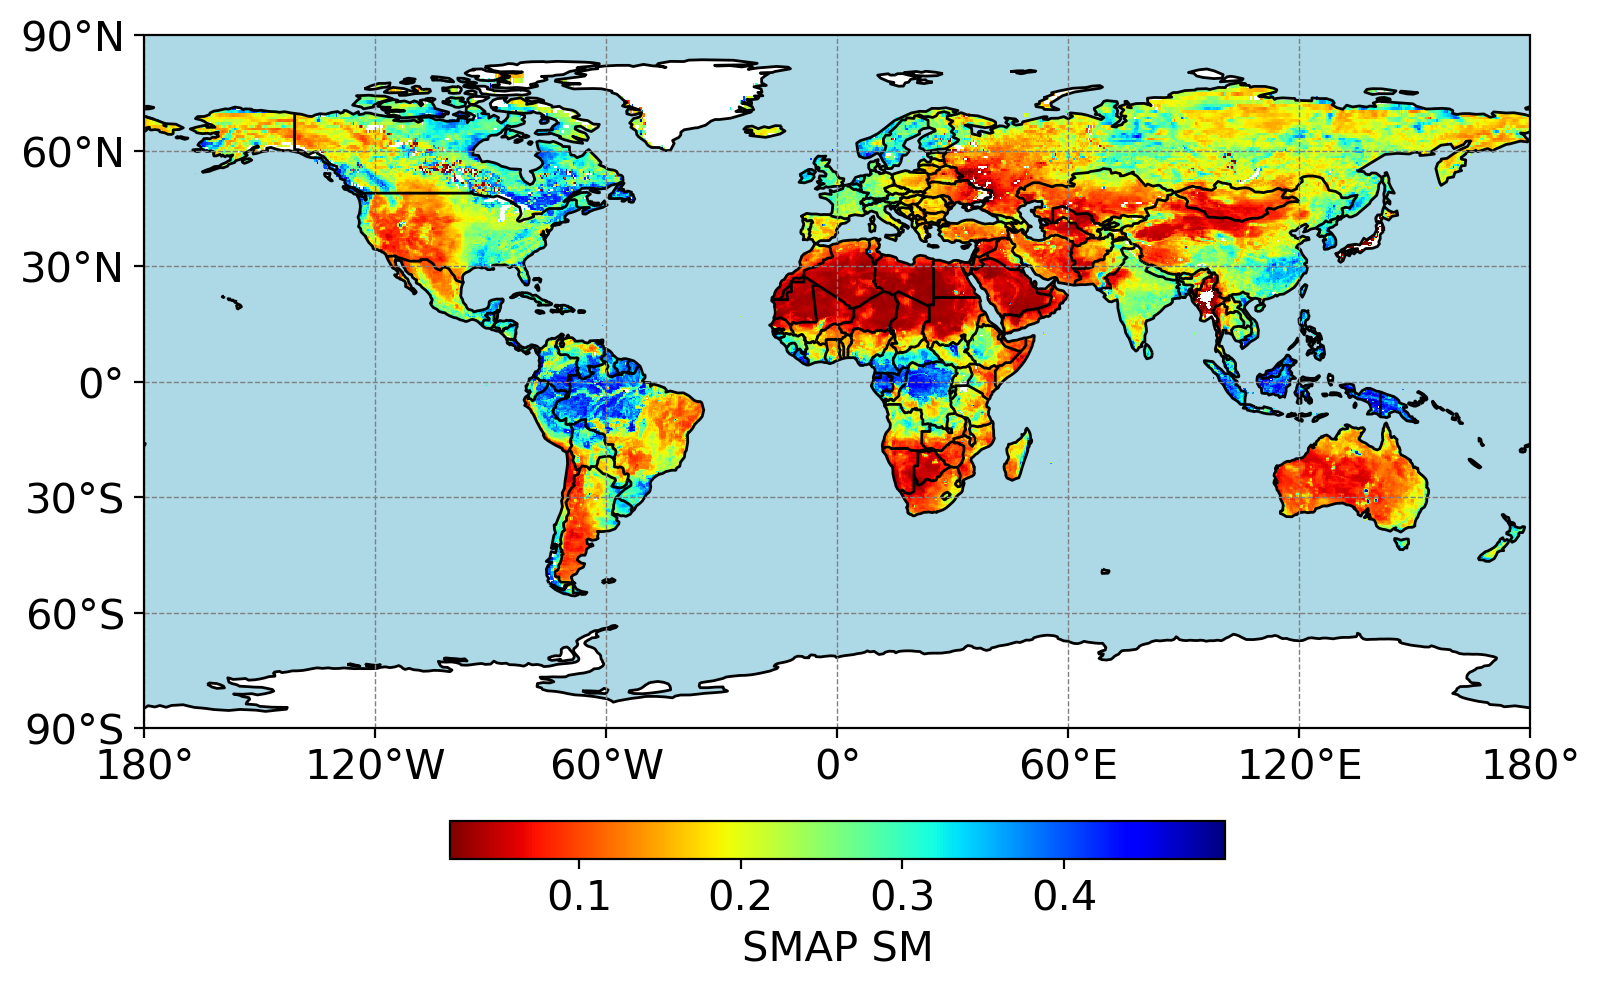

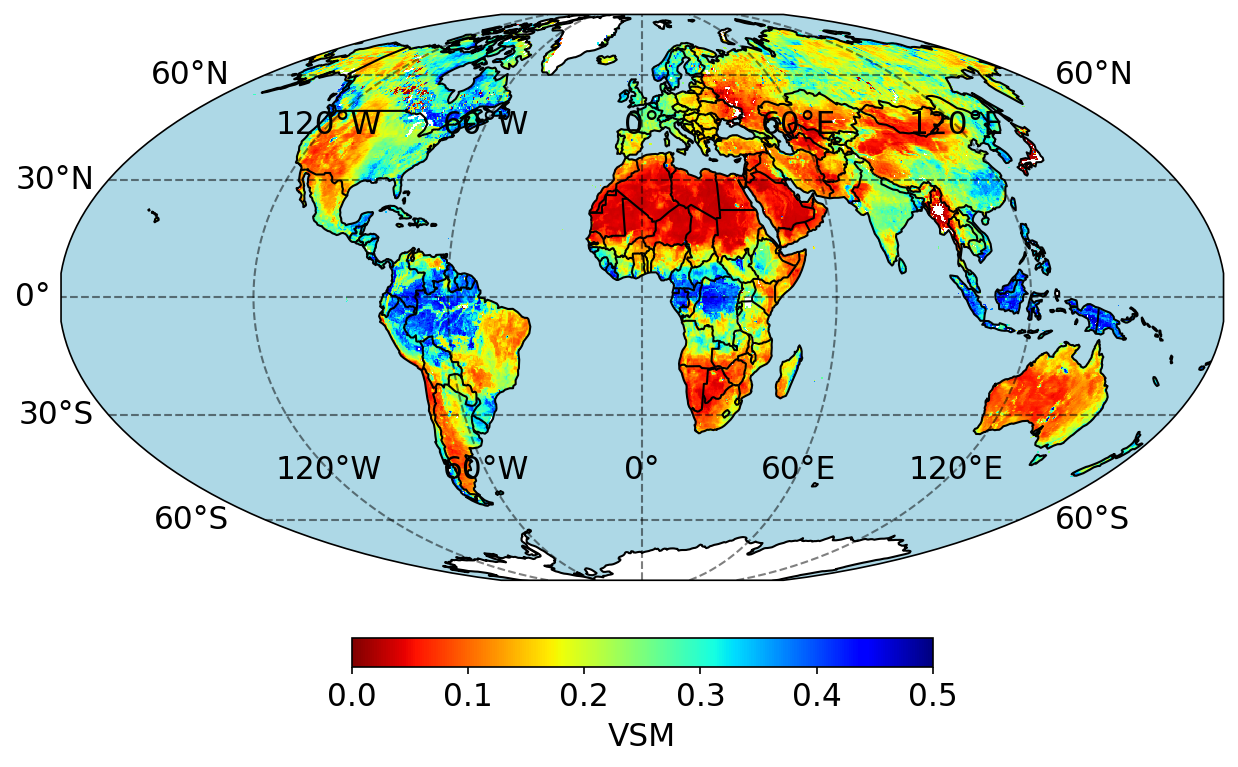

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [16]:
# Display the map with plot_global_map
nanmean_SMAP_SM_AM = np.nanmean(SMAP_SM_AM, axis=2)
target = nanmean_SMAP_SM_AM
hPlot.plot_global_map(longitude, latitude, target, 'SMAP SM', np.nanmin(target), np.nanmax(target), 'jet_r')
 
# Display the map with plot_map
hPlot.plot_map(longitude, latitude, target, 0, 0.5, plot_title='SMAP SM', label_title='VSM', cmap='jet_r', projection='Mollweide')
bounds = [125.7, 129.7, 33.9, 38.8] # entire Korea
hPlot.plot_map(longitude, latitude, target, 0, 0.5, plot_title='SMAP SM', label_title='VSM', cmap='jet_r', projection='PlateCarree', bounds=bounds)

# 2. Resample SMAP data

### 2.1. Load the domain lat/lon

In [17]:
# Resample SMAP data into GLDAS NOAH 0.25 x 0.25 grid
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.25)
print(np.shape(domain_lon), np.shape(domain_lat))

(720, 1440) (720, 1440)


In [18]:
mission = 'SMAP'
mission_product = 'SPL3SMP.008'
target_projection = 'Noah_025'

### 4.2. Resample SMAP data

In [19]:
# Variables to process
variables = [
    'soil_moisture',
    'retrieval_qual_flag',
    'tb_qual_flag_3',
    'tb_qual_flag_4',
    'soil_moisture_error',
    'vegetation_water_content'
]
start_year = 2024
end_year = 2024

for year in range(start_year, end_year + 1):
    path_list = ['am','pm']
    
    for path in path_list:
        # resample SMAP into the doamin size
        nc_file  = nc_save_dir+'/'+mission_product+'_'+str(year)+'_'+path+'.nc'
        nc_data  = netCDF4.Dataset(nc_file)

        if path == 'pm':
            SMAP_SM  = nc_data.variables['soil_moisture_'+path][:].data
            SMAP_QF  = nc_data.variables['retrieval_qual_flag_'+path][:].data.astype(int)
        else:
            SMAP_SM  = nc_data.variables['soil_moisture'][:].data
            SMAP_QF  = nc_data.variables['retrieval_qual_flag'][:].data.astype(int)
            
        SMAP_lat = nc_data.variables['latitude'][:].data
        SMAP_lon = nc_data.variables['longitude'][:].data

        # Add Other variables
        data_vars = {}
        for var in variables:
            if var in ['soil_moisture', 'retrieval_qual_flag']: # Ignore already readed variables
                continue
            if path == 'pm': variable_name = f"{var}_{path}"
            else:            variable_name = f"{var}"
            var_data = nc_data.variables[variable_name][:].data
            resampled_data  = hData.Resampling_forloop(domain_lon, domain_lat, SMAP_lon, SMAP_lat, var_data, mag_factor=3)
            data_vars[f'Resampled_{var}'] = resampled_data
        nc_data.close()
                
        # Define the mask for "Retrieval_recommended"
        retrieval_recommended_mask = 1
        
        # Apply the mask to the retrieval_qual_flag to get a boolean array where True indicates "Retrieval_recommended"
        retrieval_recommended = (SMAP_QF & retrieval_recommended_mask) != 0

        # Use broadcasting to apply the mask across the last dimension of the data_array
        SMAP_SM_QC = np.where(retrieval_recommended, SMAP_SM, np.nan)
        #SMAP_SM_QC = SMAP_SM
        Resampled_SMAP_SM = hData.Resampling_forloop(domain_lon, domain_lat, SMAP_lon, SMAP_lat, SMAP_SM, mag_factor=3)
        Resampled_SMAP_SM_QC = hData.Resampling_forloop(domain_lon, domain_lat, SMAP_lon, SMAP_lat, SMAP_SM_QC, mag_factor=3)
        
        data_vars['Resampled_SMAP_SM'] = Resampled_SMAP_SM
        data_vars['Resampled_SMAP_SM_QC'] = Resampled_SMAP_SM_QC

        # Save netCDF file        
        nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{path}_R_{target_projection}.nc')
        hData.create_netcdf_file(nc_file=nc_file_name, latitude=domain_lat, longitude=domain_lon, **data_vars)
        print(f"Data for {year} {path} saved to {nc_file_name}")

100%|██████████| 367/367 [00:46<00:00,  7.83it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_am_R_Noah_025.nc created successfully.
Data for 2024 am saved to /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_am_R_Noah_025.nc


100%|██████████| 367/367 [00:46<00:00,  7.94it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_pm_R_Noah_025.nc created successfully.
Data for 2024 pm saved to /home/subin/cpuserver_data/extracted_nc/SPL3SMP/SPL3SMP.008_2024_pm_R_Noah_025.nc


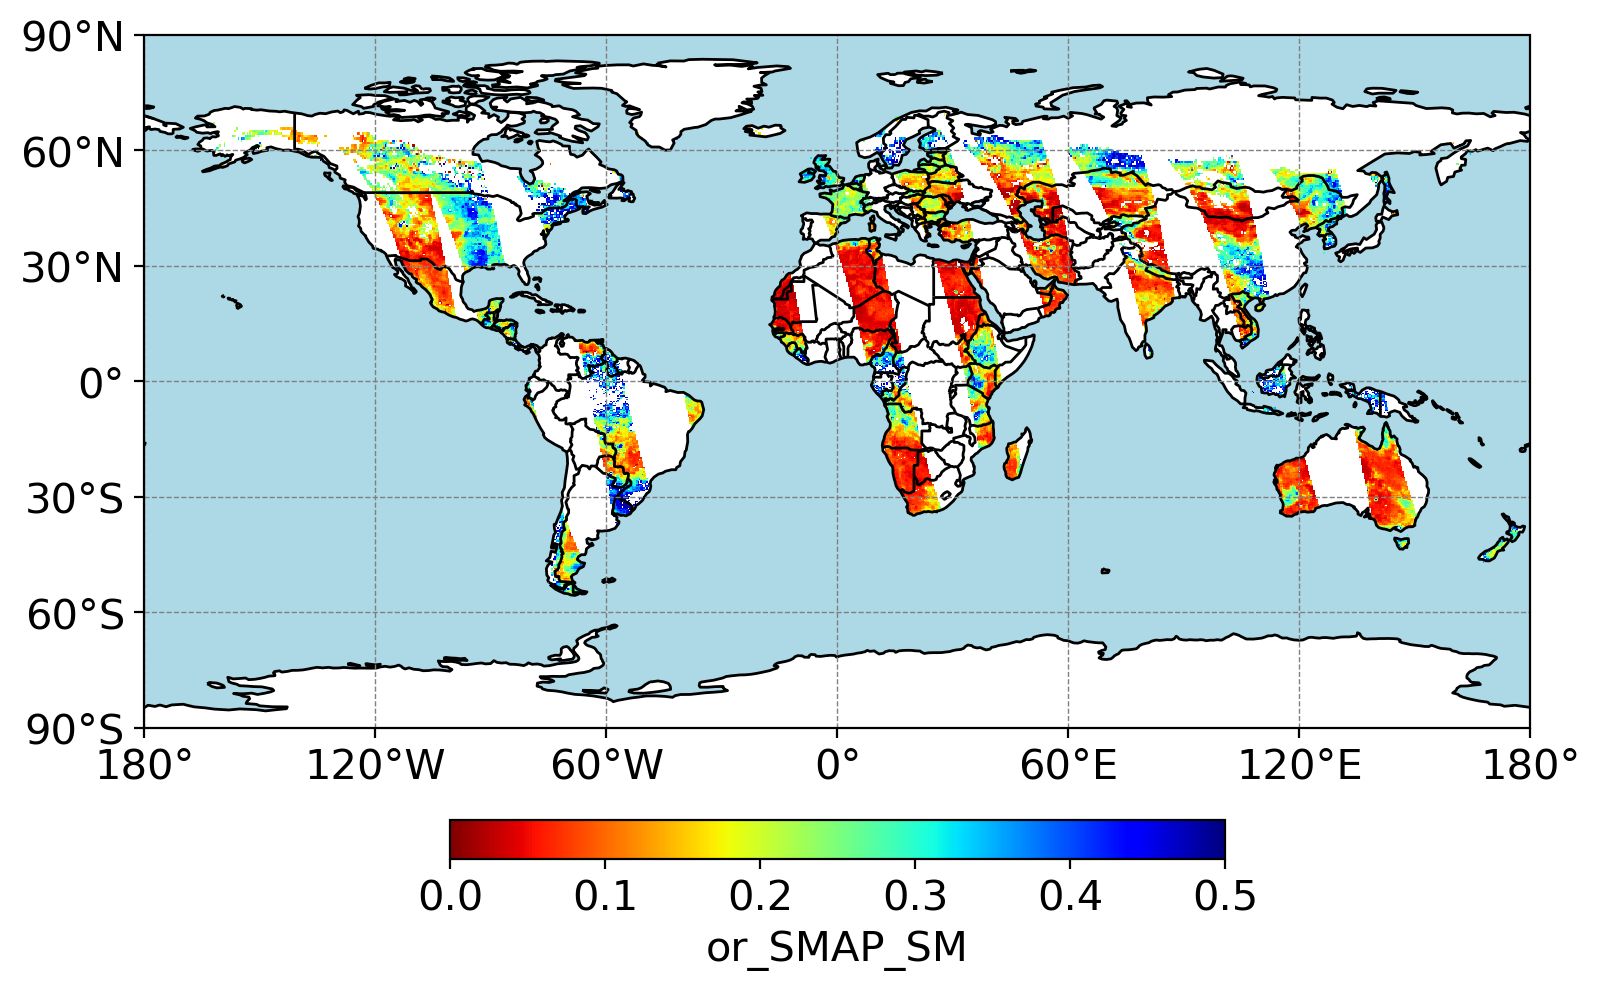

In [20]:
# Check the resampled data
doy = 121
r_smap = Resampled_SMAP_SM_QC[:,:,doy]
hPlot.plot_global_map(domain_lon, domain_lat, r_smap, 're_SMAP_SM', 0, 0.5, 'jet_r')
smap = SMAP_SM[:,:,doy]
hPlot.plot_global_map(SMAP_lon, SMAP_lat, smap, 'or_SMAP_SM', 0, 0.5, 'jet_r')

In [23]:
# Compare the SMAPL3_E- bnad SMAPL3-based Resampling Results
year = 2022
path = 'am'
target_projection = 'Noah_025' 

mission_product = 'SPL3SMP_E.005'
nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{path}_R_{target_projection}.nc')
with netCDF4.Dataset(nc_file_name) as nc_data:
    SMAPL3E_R_SM = nc_data.variables['Resampled_SMAP_SM_QC'][:,:, 150].data

mission_product = 'SPL3SMP.008'
nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{path}_R_{target_projection}.nc')
with netCDF4.Dataset(nc_file_name) as nc_data:
    SMAPL3_R_SM = nc_data.variables['Resampled_SMAP_SM_QC'][:,:, 150].data
    domain_lon = nc_data.variables['longitude'][:].data
    domain_lat = nc_data.variables['latitude'][:].data

mission_product = 'SPL3SMP.008'
nc_file_name  = nc_save_dir+'/'+mission_product+'_'+str(year)+'_'+path+'.nc'
with netCDF4.Dataset(nc_file_name) as nc_data:
    SMAPL3_or_SM = nc_data.variables['soil_moisture'][:,:, 150].data
    SMAP_lon = nc_data.variables['longitude'][:].data
    SMAP_lat = nc_data.variables['latitude'][:].data

In [24]:
hPlot.plot_global_map(domain_lon, domain_lat, SMAPL3E_R_SM, 'Re_SMAPL3_E_SM', 0, 0.5, 'jet_r')
hPlot.plot_global_map(domain_lon, domain_lat, SMAPL3_R_SM, 'Re_SMAPL3_SM', 0, 0.5, 'jet_r')
hPlot.plot_global_map(SMAP_lon, SMAP_lat, SMAPL3_or_SM, 'Or_SMAPL3_SM', 0, 0.5, 'jet_r')